## Домашнее задание

### Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой


Сравните полученные результаты, оцените какие токены наиболее важные для классификации.


### Задание 2.

найти фичи с наибольшей значимостью, и вывести их


### Задание 3.

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера 

3) убедиться что для сетки нет переобучения

In [1]:
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path) 

In [2]:
import pandas as pd
import numpy as np
import re

In [3]:
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from nltk import tokenize as tknz
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [6]:
from nltk.corpus import stopwords

In [7]:
import contractions
from string import punctuation
from collections import Counter

In [8]:
import pickle
with open('../data/Emoji_Dict.p', 'rb') as fp:
    Emoji_Dict = pickle.load(fp)
    Emoji_Dict = {v: k for k, v in Emoji_Dict.items() if ('face' in k or 'hand' in k)}

In [9]:
Emoji_Dict

{'👌': ':OK_hand:',
 '👌 🏿': ':OK_hand_dark_skin_tone:',
 '👌 🏻': ':OK_hand_light_skin_tone:',
 '👌 🏾': ':OK_hand_medium-dark_skin_tone:',
 '👌 🏼': ':OK_hand_medium-light_skin_tone:',
 '👌 🏽': ':OK_hand_medium_skin_tone:',
 '😠': ':angry_face:',
 '👿': ':angry_face_with_horns:',
 '😧': ':anguished_face:',
 '😲': ':astonished_face:',
 '👇': ':backhand_index_pointing_down:',
 '👇 🏿': ':backhand_index_pointing_down_dark_skin_tone:',
 '👇 🏻': ':backhand_index_pointing_down_light_skin_tone:',
 '👇 🏾': ':backhand_index_pointing_down_medium-dark_skin_tone:',
 '👇 🏼': ':backhand_index_pointing_down_medium-light_skin_tone:',
 '👇 🏽': ':backhand_index_pointing_down_medium_skin_tone:',
 '👈': ':backhand_index_pointing_left:',
 '👈 🏿': ':backhand_index_pointing_left_dark_skin_tone:',
 '👈 🏻': ':backhand_index_pointing_left_light_skin_tone:',
 '👈 🏾': ':backhand_index_pointing_left_medium-dark_skin_tone:',
 '👈 🏼': ':backhand_index_pointing_left_medium-light_skin_tone:',
 '👈 🏽': ':backhand_index_pointing_left_medium_sk

In [10]:
def preprocess_text(texts_list): # texts_list - an iterable of tweets
    prepared_texts = []
    
    for text in texts_list:
        
        # 1) Удалим @user из всех твитов с помощью паттерна "@[\w]*". 
        text = re.sub("@[\w]*", " ", text)
        
        # 3) Заменим сокращения с апострофами (пример: ain't, can't) на пробел & 4)Заменим сокращения на их полные формы
        expanded_words = []   
        for word in text.split():
            # using contractions.fix to expand the shortened words
            expanded_words.append(contractions.fix(word))            
        text = ' '.join(expanded_words)
        
        # 5) Заменим эмотиконы (пример: ":)" = "happy") на пробелы 
        # 
        for emot in Emoji_Dict:
            text = re.sub(r'('+emot+')', Emoji_Dict[emot], text)
        
        # 6) пунктуацию, используя re.sub() и паттерн r'[^\w\s]'
        text = re.sub(r'[^\w\s]', " ", text)
        
           
        # 9) Удалим из текста слова длиной в 1 символ, используя ' '.join([w for w in x.split() if len(w)>1])
        
        text = ' '.join([w for w in text.split() if len(w)>1])
        prepared_texts.append(text)
        
    
    return prepared_texts

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [12]:
from natasha import Doc, MorphVocab, Segmenter, NewsEmbedding, NewsMorphTagger

In [13]:
def natasha_lemmatize(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    return {_.text: _.lemma for _ in doc.tokens}

In [14]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

In [15]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('../data/positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('../data/negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

In [16]:
prepared_texts = preprocess_text(df.text)

In [17]:
df_prepared = pd.DataFrame(prepared_texts, columns=['text'])
df_prepared['label'] = df['label'].values

In [18]:
df_prepared.head(3)

,text,label
0,хоть школота но поверь нас то же самое обществ...,positive
1,Да все таки он немного похож на него Но мой ма...,positive
2,RT Ну ты идиотка испугалась за тебя,positive


In [19]:
df_prepared['text'].iloc[4]

'Вот что значит страшилка Но блин посмотрев все части тебя создастся ощущение что авторы курили что то'

In [20]:
df['text'].iloc[4]

'@irina_dyshkant Вот что значит страшилка :D\nНо блин,посмотрев все части,у тебя создастся ощущение,что авторы курили что-то :D'

In [21]:
x_train, x_test, y_train, y_test = train_test_split(df_prepared.text, df_prepared.label)

In [22]:
corpus = [token for tweet in df_prepared.text for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

2383623


['хоть',
 'школота',
 'но',
 'поверь',
 'нас',
 'то',
 'же',
 'самое',
 'общество',
 'профилирующий']

In [23]:
freq_dict = Counter(corpus)
freq_dict_sorted = sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('не', 69730),
 ('RT', 38076),
 ('на', 35842),
 ('что', 33767),
 ('http', 33063),
 ('co', 33036),
 ('меня', 20769),
 ('то', 20245),
 ('как', 19461),
 ('так', 17053)]

In [24]:
first_50_freqs = [freq for word, freq in freq_dict_sorted[:50]]
first_300_freqs = [freq for word, freq in freq_dict_sorted[:300]]
first_100_freqs = [freq for word, freq in freq_dict_sorted[:100]]


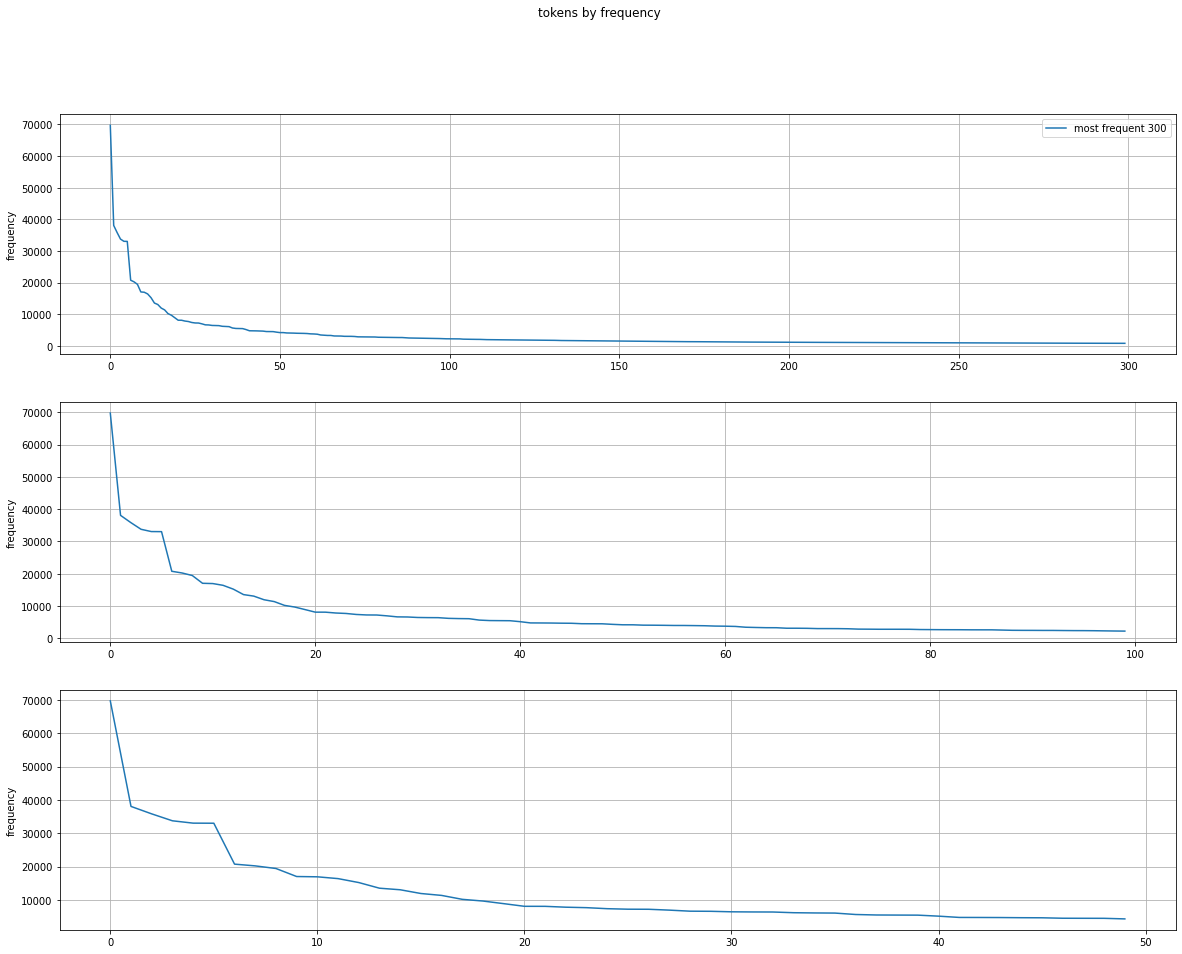

In [25]:
fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

fig.suptitle('tokens by frequency')
  # drawing a graph
ax1.plot(first_300_freqs, label = 'most frequent 300')
ax2.plot(first_100_freqs, label = 'most frequent 100')
ax3.plot(first_50_freqs, label = 'most frequent 50')


ax1.set_ylabel('frequency')
ax1.legend()
ax1.grid('On')

ax2.set_ylabel('frequency')
#ax2.legend()
ax2.grid('On')

ax3.set_ylabel('frequency')
#ax3.legend()
ax3.grid('On')
plt.show()


In [26]:
noise = stopwords.words('russian') + list(punctuation)

tweets_clean = [token for tweet in df.text for token in word_tokenize(tweet) if token not in noise]
print(len(tweets_clean))
tweets_clean[:10]

freq_tweets_clean = Counter(tweets_clean)
freq_tweets_clean_sorted= sorted(freq_tweets_clean.items(), key=lambda x: -x[1])
list(freq_tweets_clean_sorted)[:10]

In [27]:
vocab_50_1000 = list(zip(*freq_dict_sorted[50:1000]))[0]
vocab_50_500 = list(zip(*freq_dict_sorted[50:500]))[0]
vocab_100_1000 = list(zip(*freq_dict_sorted[100:1000]))[0]
vocab_100_500 = list(zip(*freq_dict_sorted[100:500]))[0]

**building vectorizers with diff. params and varying arguements**

In [28]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise)
vec_max_1000 = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise, max_features = 1000)
vec_max_500 = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise, max_features = 500)
vec_max_100 = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise, max_features = 100)
vec_max_50 = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise, max_features = 50)
vec_50_1000 = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, vocabulary=vocab_50_1000)
vec_50_500 = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, vocabulary=vocab_50_500)
vec_100_1000 = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, vocabulary=vocab_100_1000)
vec_100_500 = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, vocabulary=vocab_100_500)


In [29]:
bow = vec.fit_transform(x_train)
bow_max_1000 = vec_max_1000.fit_transform(x_train)
bow_max_500 = vec_max_500.fit_transform(x_train)
bow_max_100 = vec_max_100.fit_transform(x_train)
bow_max_50 = vec_max_50.fit_transform(x_train)
bow_50_1000 = vec_50_1000.fit_transform(x_train)
bow_50_500 = vec_50_500.fit_transform(x_train)
bow_100_1000 = vec_100_1000.fit_transform(x_train)
bow_100_500 = vec_100_500.fit_transform(x_train)

C:\Users\Armik\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  % sorted(inconsistent)
C:\Users\Armik\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"


max_features : int, default=None
    If not None, build a vocabulary that only consider the top
    max_features ordered by term frequency across the corpus.

    This parameter is ignored if vocabulary is not None.

vocabulary : Mapping or iterable, default=None
    Either a Mapping (e.g., a dict) where keys are terms and values are
    indices in the feature matrix, or an iterable over terms. If not
    given, a vocabulary is determined from the input documents. Indices
    in the mapping should not be repeated and should not have any gap
    between 0 and the largest index.

**original TfidfVectorizer on all tokens**

In [30]:
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)


C:\Users\Armik\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=42)

In [31]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.70      0.75      0.73     26170
    positive       0.77      0.73      0.75     30539

    accuracy                           0.74     56709
   macro avg       0.74      0.74      0.74     56709
weighted avg       0.74      0.74      0.74     56709



**TfidfVectorizer on 1000 most frequent tokens**

In [33]:
clf_max_1000 = LogisticRegression(random_state=42)
clf_max_1000.fit(bow_max_1000, y_train)

C:\Users\Armik\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=42)

In [34]:
pred_max_1000 = clf_max_1000.predict(vec_max_1000.transform(x_test))
print(classification_report(pred_max_1000, y_test))

              precision    recall  f1-score   support

    negative       0.66      0.67      0.67     27370
    positive       0.69      0.67      0.68     29339

    accuracy                           0.67     56709
   macro avg       0.67      0.67      0.67     56709
weighted avg       0.67      0.67      0.67     56709



**TfidfVectorizer on 500 most frequent tokens**

In [35]:
clf_max_500 = LogisticRegression(random_state=42)
clf_max_500.fit(bow_max_500, y_train)

C:\Users\Armik\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=42)

In [36]:
pred_max_500 = clf_max_500.predict(vec_max_500.transform(x_test))
print(classification_report(pred_max_500, y_test))

              precision    recall  f1-score   support

    negative       0.65      0.65      0.65     28209
    positive       0.66      0.66      0.66     28500

    accuracy                           0.66     56709
   macro avg       0.66      0.66      0.66     56709
weighted avg       0.66      0.66      0.66     56709



**TfidfVectorizer on 100 most frequent tokens**

In [37]:
clf_max_100 = LogisticRegression(random_state=42)
clf_max_100.fit(bow_max_100, y_train)

LogisticRegression(random_state=42)

In [38]:
pred_max_100 = clf_max_100.predict(vec_max_100.transform(x_test))
print(classification_report(pred_max_100, y_test))

              precision    recall  f1-score   support

    negative       0.67      0.59      0.63     31898
    positive       0.55      0.63      0.58     24811

    accuracy                           0.61     56709
   macro avg       0.61      0.61      0.61     56709
weighted avg       0.62      0.61      0.61     56709



**TfidfVectorizer on 50 most frequent tokens**

In [39]:
clf_max_50 = LogisticRegression(random_state=42)
clf_max_50.fit(bow_max_50, y_train)

LogisticRegression(random_state=42)

In [40]:
pred_max_50 = clf_max_50.predict(vec_max_50.transform(x_test))
print(classification_report(pred_max_50, y_test))

              precision    recall  f1-score   support

    negative       0.68      0.57      0.62     33383
    positive       0.50      0.62      0.55     23326

    accuracy                           0.59     56709
   macro avg       0.59      0.59      0.59     56709
weighted avg       0.61      0.59      0.59     56709



**TfidfVectorizer on most frequent tokens in range 50 - 1000**

In [41]:
clf_50_1000 = LogisticRegression(random_state=42)
clf_50_1000.fit(bow_50_1000, y_train)

LogisticRegression(random_state=42)

In [42]:
pred_50_1000 = clf_50_1000.predict(vec_50_1000.transform(x_test))
print(classification_report(pred_50_1000, y_test))

              precision    recall  f1-score   support

    negative       0.57      0.69      0.62     23270
    positive       0.75      0.64      0.69     33439

    accuracy                           0.66     56709
   macro avg       0.66      0.66      0.66     56709
weighted avg       0.67      0.66      0.66     56709



**TfidfVectorizer on most frequent tokens in range 50 - 500**

In [43]:
clf_50_500 = LogisticRegression(random_state=42)
clf_50_500.fit(bow_50_500, y_train)

LogisticRegression(random_state=42)

In [44]:
pred_50_500 = clf_50_500.predict(vec_50_500.transform(x_test))
print(classification_report(pred_50_500, y_test))

              precision    recall  f1-score   support

    negative       0.51      0.66      0.58     21854
    positive       0.74      0.61      0.67     34855

    accuracy                           0.63     56709
   macro avg       0.63      0.63      0.62     56709
weighted avg       0.65      0.63      0.63     56709



**TfidfVectorizer on most frequent tokens in range 100 - 1000**

In [45]:
clf_100_1000 = LogisticRegression(random_state=42)
clf_100_1000.fit(bow_100_1000, y_train)

LogisticRegression(random_state=42)

In [46]:
pred_100_1000 = clf_100_1000.predict(vec_100_1000.transform(x_test))
print(classification_report(pred_100_1000, y_test))

              precision    recall  f1-score   support

    negative       0.53      0.68      0.60     22186
    positive       0.75      0.62      0.68     34523

    accuracy                           0.64     56709
   macro avg       0.64      0.65      0.64     56709
weighted avg       0.67      0.64      0.65     56709



**TfidfVectorizer on most frequent tokens in range 100 - 500**

In [47]:
clf_100_500 = LogisticRegression(random_state=42)
clf_100_500.fit(bow_100_500, y_train)

LogisticRegression(random_state=42)

In [48]:
pred_100_500 = clf_100_500.predict(vec_100_500.transform(x_test))
print(classification_report(pred_100_500, y_test))

              precision    recall  f1-score   support

    negative       0.46      0.65      0.54     19876
    positive       0.76      0.59      0.66     36833

    accuracy                           0.61     56709
   macro avg       0.61      0.62      0.60     56709
weighted avg       0.65      0.61      0.62     56709



first 50 features seem to be more critical for detecting negative tweets, and more rare (from 1000th) for positive. For linear regression model reducing the number of features seems to be unreasonable 

In [75]:
importance_1000_features = pd.DataFrame({'feature': list(vec_max_1000.vocabulary_.keys()), 'coeff': clf_max_1000.coef_[0]},
                                        columns=['feature', 'coeff'])

In [77]:
sort_importance_1000 = importance_1000_features.sort_values('coeff', axis=0, ascending=True)

In [78]:
sort_importance_1000

,feature,coeff
33,буду,-6.603334
530,тож,-4.716771
531,голос,-4.463395
584,сидит,-4.213940
171,готова,-4.054890
...,...,...
51,первый,2.907279
532,че,2.948030
671,смешно,3.168328
26,неужели,6.090281
